# Project Reviews Aggregator

## Import libraries

In [83]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer



## Data cleaning

### Load Kaggle data

In [84]:
# Loading data from kaggle

import kagglehub

# Download latest version
path_kaggle = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path_kaggle)

Path to dataset files: C:\Users\aurel\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5


In [85]:
import pandas as pd
import os


# List all CSV files in the directory
csv_files = [file for file in os.listdir(path_kaggle) if file.endswith('.csv')]

# Iterate through each CSV file and print its headers
for file in csv_files:
    file_path = os.path.join(path_kaggle, file)
    df = pd.read_csv(file_path, low_memory=False)
    print(f"Headers for {file}:")
    for header in df.columns:
        print(header)
    print("\n" + "-" * 50 + "\n")  # Separator for better readability


Headers for 1429_1.csv:
id
name
asins
brand
categories
keys
manufacturer
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.didPurchase
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.userCity
reviews.userProvince
reviews.username

--------------------------------------------------

Headers for Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv:
id
dateAdded
dateUpdated
name
asins
brand
categories
primaryCategories
imageURLs
keys
manufacturer
manufacturerNumber
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.username
sourceURLs

--------------------------------------------------

Headers for Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv:
id
dateAdded
dateUpdated
name
asins
brand
categories
primaryCategories
imageURLs
keys
manufacturer
manufacturerNumber
reviews.date
rev

In [86]:
######## Create Kaggle dataframe with the 3 review csv ########

"""
# List all CSV files in the directory
csv_files = [file for file in os.listdir(path_kaggle) if file.endswith('.csv')]

# Combine all CSV files into a single DataFrame
dataframes = []
for file in csv_files:
    file_path = os.path.join(path_kaggle, file)
    df = pd.read_csv(file_path, low_memory=False)  # Prevent dtype warnings
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame, aligning columns
kag_comb = pd.concat(dataframes, ignore_index=True, sort=True)

# Define the project directory
project_dir = os.getcwd()  # Gets the current working directory

# Path to the "data" folder in the project directory
data_dir = os.path.join(project_dir, "data")

# Ensure the "data" folder exists
os.makedirs(data_dir, exist_ok=True)

# Save the combined DataFrame to a new CSV file in the "data" folder
kag_comb_path = os.path.join(data_dir, "kag_comb.csv")
kag_comb.to_csv(kag_comb_path, index=False)

print(f"Combined CSV saved to {kag_comb_path}")
"""


######## Load generated CSV ########

kag_comb = pd.read_csv("data/kag_comb.csv")


C:\Users\aurel\AppData\Local\Temp\ipykernel_30884\737699756.py:36: DtypeWarning: Columns (3,4,6,9,11,13,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  kag_comb = pd.read_csv("data/kag_comb.csv")


### Clean Kaggle data

In [87]:
#Check df heads

# List of columns to drop
columns_to_drop = [
    'dateAdded',
    'dateUpdated',
    'reviews.didPurchase',
    'reviews.userCity',
    'reviews.userProvince',
    'asins',
    'imageURLs',
    'manufacturerNumber',
    'primaryCategories',
    'sourceURLs',
    'reviews.sourceURLs',
    'keys',
    'reviews.date',
    'reviews.dateAdded',
    'reviews.dateSeen',
    'reviews.numHelpful'
]

# Drop the columns from the dataframe
kag_comb = kag_comb.drop(columns=columns_to_drop)


# Get a list of all column headers
headers = kag_comb.columns.tolist()

# Display the headers
for header in headers:
    print(header)


brand
categories
id
manufacturer
name
reviews.doRecommend
reviews.id
reviews.rating
reviews.text
reviews.title
reviews.username


In [88]:
kag_comb.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,This product so far has not disappointed. My c...,Kindle,Adapter
1,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,great for beginner or experienced person. Boug...,very fast,truman
2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ
3,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks
4,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42


In [89]:
# Check for duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id' columns
duplicates = kag_comb.duplicated(subset=['reviews.text', 'reviews.username', 'reviews.id'])

# Count the number of duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id': {num_duplicates}")

# If you want to display the duplicate rows
if num_duplicates > 0:
    duplicate_rows = kag_comb[duplicates]
    print("Duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id':")
    print(duplicate_rows)


Number of duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id': 19898
Duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id':
        brand                                         categories  \
34660  Amazon  Computers,Electronics Features,Tablets,Electro...   
34661  Amazon  Computers,Electronics Features,Tablets,Electro...   
34665  Amazon  Computers,Electronics Features,Tablets,Electro...   
34667  Amazon  Computers,Electronics Features,Tablets,Electro...   
34670  Amazon  Computers,Electronics Features,Tablets,Electro...   
...       ...                                                ...   
67987  Amazon  Fire Tablets,Tablets,All Tablets,Amazon Tablet...   
67988  Amazon  Fire Tablets,Tablets,All Tablets,Amazon Tablet...   
67989  Amazon  Fire Tablets,Tablets,All Tablets,Amazon Tablet...   
67990  Amazon  Fire Tablets,Tablets,All Tablets,Amazon Tablet...   
67991  Amazon  Fire Tablets,Tablets,All Tablets,Amazon Tablet...   

                   

In [90]:
# Create a new dataframe with duplicates removed based on 'reviews.text', 'reviews.username' and 'id'
kag_comb_clean = kag_comb.drop_duplicates(subset=['reviews.text', 'reviews.username', 'reviews.id'])

# Remove rows with NaN in 'reviews.rating'
kag_comb_clean = kag_comb_clean.dropna(subset=['reviews.rating'])

# Remove rows with NaN in 'reviews.title'
kag_comb_clean = kag_comb_clean.dropna(subset=['reviews.title'])

# Verify the new dataframe
print(f"New dataframe shape: {kag_comb_clean.shape}")


New dataframe shape: (48044, 11)


In [91]:
# Check for NaN values in the 'reviews.ratingtext' column
nan_reviews_ratingtext = kag_comb_clean['reviews.rating'].isna()

# Count the number of NaN values
num_nan_reviews_ratingtext = nan_reviews_ratingtext.sum()
print(f"Number of NaN values in 'reviews.rating': {num_nan_reviews_ratingtext}")

# Display rows with NaN values in 'reviews.ratingtext'
if num_nan_reviews_ratingtext > 0:
    rows_with_nan = kag_comb_clean[nan_reviews_ratingtext]
    print("Rows with NaN in 'reviews.rating':")
    print(rows_with_nan)

Number of NaN values in 'reviews.rating': 0


### Add missing data for classification training

In [92]:
# Fill NaN values in 'reviews.doRecommend' based on 'reviews.rating'
kag_comb_clean['reviews.doRecommend'] = kag_comb_clean['reviews.doRecommend'].fillna(
    kag_comb_clean['reviews.rating'] > 3
)

# Verify the changes
print(kag_comb_clean['reviews.doRecommend'].isna().sum())

0


C:\Users\aurel\AppData\Local\Temp\ipykernel_30884\2941269796.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kag_comb_clean['reviews.doRecommend'] = kag_comb_clean['reviews.doRecommend'].fillna(


In [93]:
# Check for NaN values in the 'reviews.doRecommend' column
nan_reviews_text = kag_comb_clean['reviews.doRecommend'].isna()

# Count the number of NaN values
num_nan_reviews_text = nan_reviews_text.sum()
print(f"Number of NaN values in 'reviews.doRecommend': {num_nan_reviews_text}")

# Display rows with NaN values in 'reviews.text'
if num_nan_reviews_text > 0:
    rows_with_nan = kag_comb_clean[nan_reviews_text]
    print("Rows with NaN in 'reviews.doRecommend':")
    print(rows_with_nan)

Number of NaN values in 'reviews.doRecommend': 0


## Preprocessing for sentiment training

### Adding sentiment traning targets

In [94]:
def classify_sentiment(rating):
    if rating <= 2:
        return "NEG"
    elif rating == 3:
        return "NEU"
    else:
        return "POS"

kag_comb_clean['sentiment'] = kag_comb_clean['reviews.rating'].apply(classify_sentiment)

kag_comb_clean.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,POS
1,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,great for beginner or experienced person. Boug...,very fast,truman,POS
2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ,POS
3,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks,POS
4,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42,POS


# Implementing PySentimiento for sentiment analysis

Selected as it is the most accurate model according to this benchmark:<br/>
https://medium.com/@pavlo.fesenko/best-open-source-models-for-sentiment-analysis-part-2-neural-networks-9749fb5fff76<br/>
Strategy is to generate sentiment in new columns through GPUs in Google colab and to go back to CPU in VScode for the rest of the project.

In [95]:
# def classify_sentiment_with_scores(text):
#     if not isinstance(text, str) or text.strip() == "":
#         return None  # Handle empty or non-string values gracefully
    
#     result = analyzer.predict(text)
#     return {
#         "label": result.output,  # Sentiment label
#         "probas": result.probas  # Probability scores
#     }

# kag_comb_clean['title sentiment details'] = kag_comb_clean['clean title'].apply(classify_sentiment_with_scores)
# kag_comb_clean['review sentiment details'] = kag_comb_clean['clean review'].apply(classify_sentiment_with_scores)


# def merge_probabilities(row):
#     if row['title sentiment details'] and row['review sentiment details']:
#         title_probas = row['title sentiment details']['probas']
#         review_probas = row['review sentiment details']['probas']
#         # Average the probabilities
#         combined_probas = {k: (title_probas[k] + review_probas[k]) / 2 for k in title_probas}
#         # Return the label with the highest combined probability
#         return max(combined_probas, key=combined_probas.get)
#     elif row['title sentiment details']:
#         return row['title sentiment details']['label']
#     elif row['review sentiment details']:
#         return row['review sentiment details']['label']
#     return None  # Handle empty rows

# kag_comb_clean['merged sentiment'] = kag_comb_clean.apply(merge_probabilities, axis=1)


**<span style="color: #ff0000;"> PySentimiento is taking superlong to run even with GPU, moving to Vader in VS Code while Sentimiento runs on Colab.</span>**

Detailed results available in Main_PySentimiento_Review_evaluation

Generated with same logic implemented for Vader below and minimal text cleaning

In [96]:
# Importing PySentimiento generated CSV

kag_comb_clean_PySentimiento = pd.read_csv("data/kag_comb_clean_PySentimiento.csv")

In [97]:
kag_comb_clean_PySentimiento.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment,clean title,clean review,title sentiment,review sentiment,title sentiment details,review sentiment details,merged PySent sentiment,PySent correct
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,llyyue,NEU,too small,i thought it would be as big as small paper bu...,NEU,NEG,"{'label': 'NEU', 'probas': {'NEG': 0.214903503...","{'label': 'NEG', 'probas': {'NEG': 0.880224943...",NEG,False
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,POS,great light reader. easy to use at the beach,this kindle is light and easy to use especiall...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001225944...","{'label': 'POS', 'probas': {'NEG': 0.001145137...",POS,True
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,POS,great for the price,didnt know how much i'd use a kindle so went f...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.022799693...","{'label': 'POS', 'probas': {'NEG': 0.002035730...",POS,True
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,POS,a great buy,i am 100 happy with my purchase. i caught it o...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.002319600...","{'label': 'POS', 'probas': {'NEG': 0.002211279...",POS,True
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,POS,solid entry-level kindle. great for kids,solid entry level kindle. great for kids. gift...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001506322...","{'label': 'POS', 'probas': {'NEG': 0.001497109...",POS,True


### PySentimiento Evaluation

PySent Accuracy: 90.45%
Confusion Matrix:


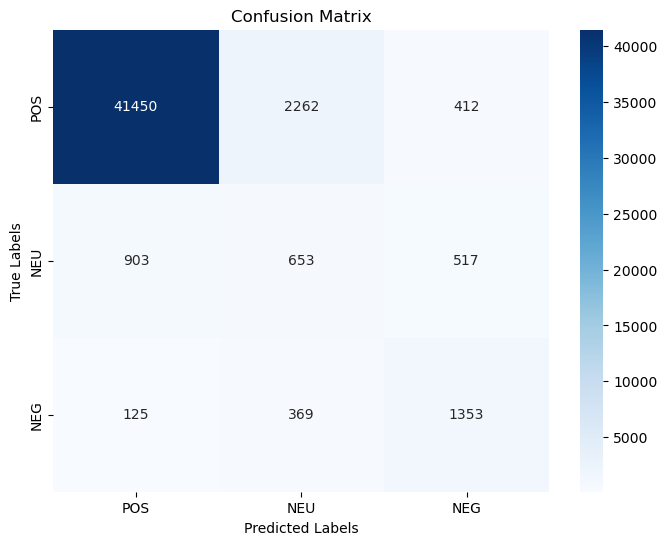

In [98]:
### PySentimiento Evaluation

# Compare ground-truth and predicted sentiment
kag_comb_clean_PySentimiento['PySent correct'] = kag_comb_clean_PySentimiento['sentiment'] == kag_comb_clean_PySentimiento['merged PySent sentiment']

pysent_accuracy = kag_comb_clean_PySentimiento['PySent correct'].mean()
print(f"PySent Accuracy: {pysent_accuracy:.2%}")

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get ground truth and predictions
y_true = kag_comb_clean_PySentimiento['sentiment']
y_pred = kag_comb_clean_PySentimiento['merged PySent sentiment']

# Generate confusion matrix
labels = ['POS', 'NEU', 'NEG']  # Replace with the actual labels used in your dataset
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Print confusion matrix
print("Confusion Matrix:")

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [99]:
from sklearn.metrics import classification_report, accuracy_score

# Generate classification report
report = classification_report(y_true, y_pred, labels=['POS', 'NEU', 'NEG'], target_names=['Positive', 'Neutral', 'Negative'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print the classification report and accuracy
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2%}")


Classification Report:
              precision    recall  f1-score   support

    Positive       0.98      0.94      0.96     44124
     Neutral       0.20      0.32      0.24      2073
    Negative       0.59      0.73      0.66      1847

    accuracy                           0.90     48044
   macro avg       0.59      0.66      0.62     48044
weighted avg       0.93      0.90      0.91     48044

Accuracy: 90.45%


# Implementing Vader

### Functions for text cleaning

In [100]:
import re

def clean_for_vader(text):
    """
    Cleans text for VADER by removing irrelevant artefacts while preserving sentiment-rich features.
    """
    if not isinstance(text, str):
        return ""

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Return the cleaned text without lowercasing or removing punctuation/emojis
    return text


In [101]:
kag_comb_clean['clean title for vader'] = kag_comb_clean['reviews.title'].apply(clean_for_vader)
kag_comb_clean['clean review for vader'] = kag_comb_clean['reviews.text'].apply(clean_for_vader)

In [102]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def classify_vader_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or non-string values gracefully
    
    scores = sia.polarity_scores(text)  # Use the initialized sia object
    compound_score = scores['compound']  # Compound score is the overall sentiment score

    # Classify based on compound score
    if compound_score >= 0.05:
        return "POS"
    elif compound_score <= -0.05:
        return "NEG"
    else:
        return "NEU"
    
# Add sentiment score
def get_vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or non-string values gracefully
    
    return sia.polarity_scores(text)  # Return the full score dictionary



# Apply VADER to the columns
kag_comb_clean['title sentiment - vader'] = kag_comb_clean['clean title for vader'].apply(classify_vader_sentiment)
kag_comb_clean['review sentiment- vader'] = kag_comb_clean['clean review for vader'].apply(classify_vader_sentiment)
kag_comb_clean['title sentiment score - vader'] = kag_comb_clean['clean title for vader'].apply(get_vader_scores)
kag_comb_clean['review sentiment score - vader'] = kag_comb_clean['clean review for vader'].apply(get_vader_scores)

In [103]:
def merge_vader_scores(row):
    title_score = row['title sentiment score - vader']['compound'] if row['title sentiment score - vader'] else 0
    review_score = row['review sentiment score - vader']['compound'] if row['review sentiment score - vader'] else 0

    # Calculate weighted sentiment score
    combined_score = (title_score*1.2 + review_score*1) / 2

    # Classify sentiment based on the combined score
    if combined_score >= 0.05:
        return "POS"
    elif combined_score <= -0.05:
        return "NEG"
    else:
        return "NEU"

# Apply the merging logic based on scores
kag_comb_clean['merged sentiment - vader'] = kag_comb_clean.apply(merge_vader_scores, axis=1)



In [104]:
kag_comb_clean.head(1)

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment,clean title for vader,clean review for vader,title sentiment - vader,review sentiment- vader,title sentiment score - vader,review sentiment score - vader,merged sentiment - vader
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,POS,Kindle,This product so far has not disappointed. My c...,NEU,POS,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",POS


In [105]:
# Compare ground-truth and predicted sentiment
kag_comb_clean['vader correct'] = kag_comb_clean['sentiment'] == kag_comb_clean['merged sentiment - vader']

In [106]:
vader_accuracy = kag_comb_clean['vader correct'].mean()
print(f"vader Accuracy: {vader_accuracy:.2%}")

vader Accuracy: 89.21%


In [107]:
kag_comb_clean.head(1)

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment,clean title for vader,clean review for vader,title sentiment - vader,review sentiment- vader,title sentiment score - vader,review sentiment score - vader,merged sentiment - vader,vader correct
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",AVqkIhwDv8e3D1O-lebb,Amazon,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",True,NaN,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,POS,Kindle,This product so far has not disappointed. My c...,NEU,POS,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",POS,True


## Comparing results

It can be argued that ratings are not proper human validated labeling

Crossing the 2 models could provide outliers that are intesting to study for modle improvement

-> Will Get back here if I have time

# WINNER

Sentiment analysis using PySentimiento!

SyntaxError: invalid syntax (1805737252.py, line 1)